<a href="https://colab.research.google.com/github/nicollenonato/log_dados_fotovoltaicos/blob/main/An%C3%A1lise_de_Desempenho_Fotovoltaico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install pm4py

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import networkx as nx
from scipy.stats import linregress
import pm4py

df = pd.read_csv('log_dados_fotovoltaicos.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [39]:
# Pré-processamento

# 📌 Definir constantes do módulo fotovoltaico
T_NOCT = 45  # Temperatura Nominal da Célula (°C)
T_a_NOCT = 20  # Temperatura ambiente nominal (°C)
G_NOCT = 800  # Irradiância nominal (W/m²)
potencia_painel = 185  # Potência nominal do painel (W)

# 📌 Calcular a temperatura da célula (Tc)
df['Tc'] = df['Temperatura_Modulo(°C)'] + (T_NOCT - T_a_NOCT) * (df['Irradiancia_Solar(W/m²)'] / G_NOCT)

# 📌 Número de painéis fotovoltaicos (npv) assumindo 185W por painel
df['npv'] = df['Potencia_Gerada(W)'] / potencia_painel

# 📌 Potência total gerada pelos painéis (Ppv)
df['Ppv'] = df['npv'] * potencia_painel

# 📌 Cálculo do desempenho do sistema (% de eficiência)
df['Desempenho'] = (df['Potencia_Gerada(W)'] / df['Ppv']) * 100

# 📌 Salvar DataFrame processado
df.to_csv('dados_processados.csv', index=False)

print("✅ Dados processados e salvos em 'dados_processados.csv'.")


✅ Dados processados e salvos em 'dados_processados.csv'.


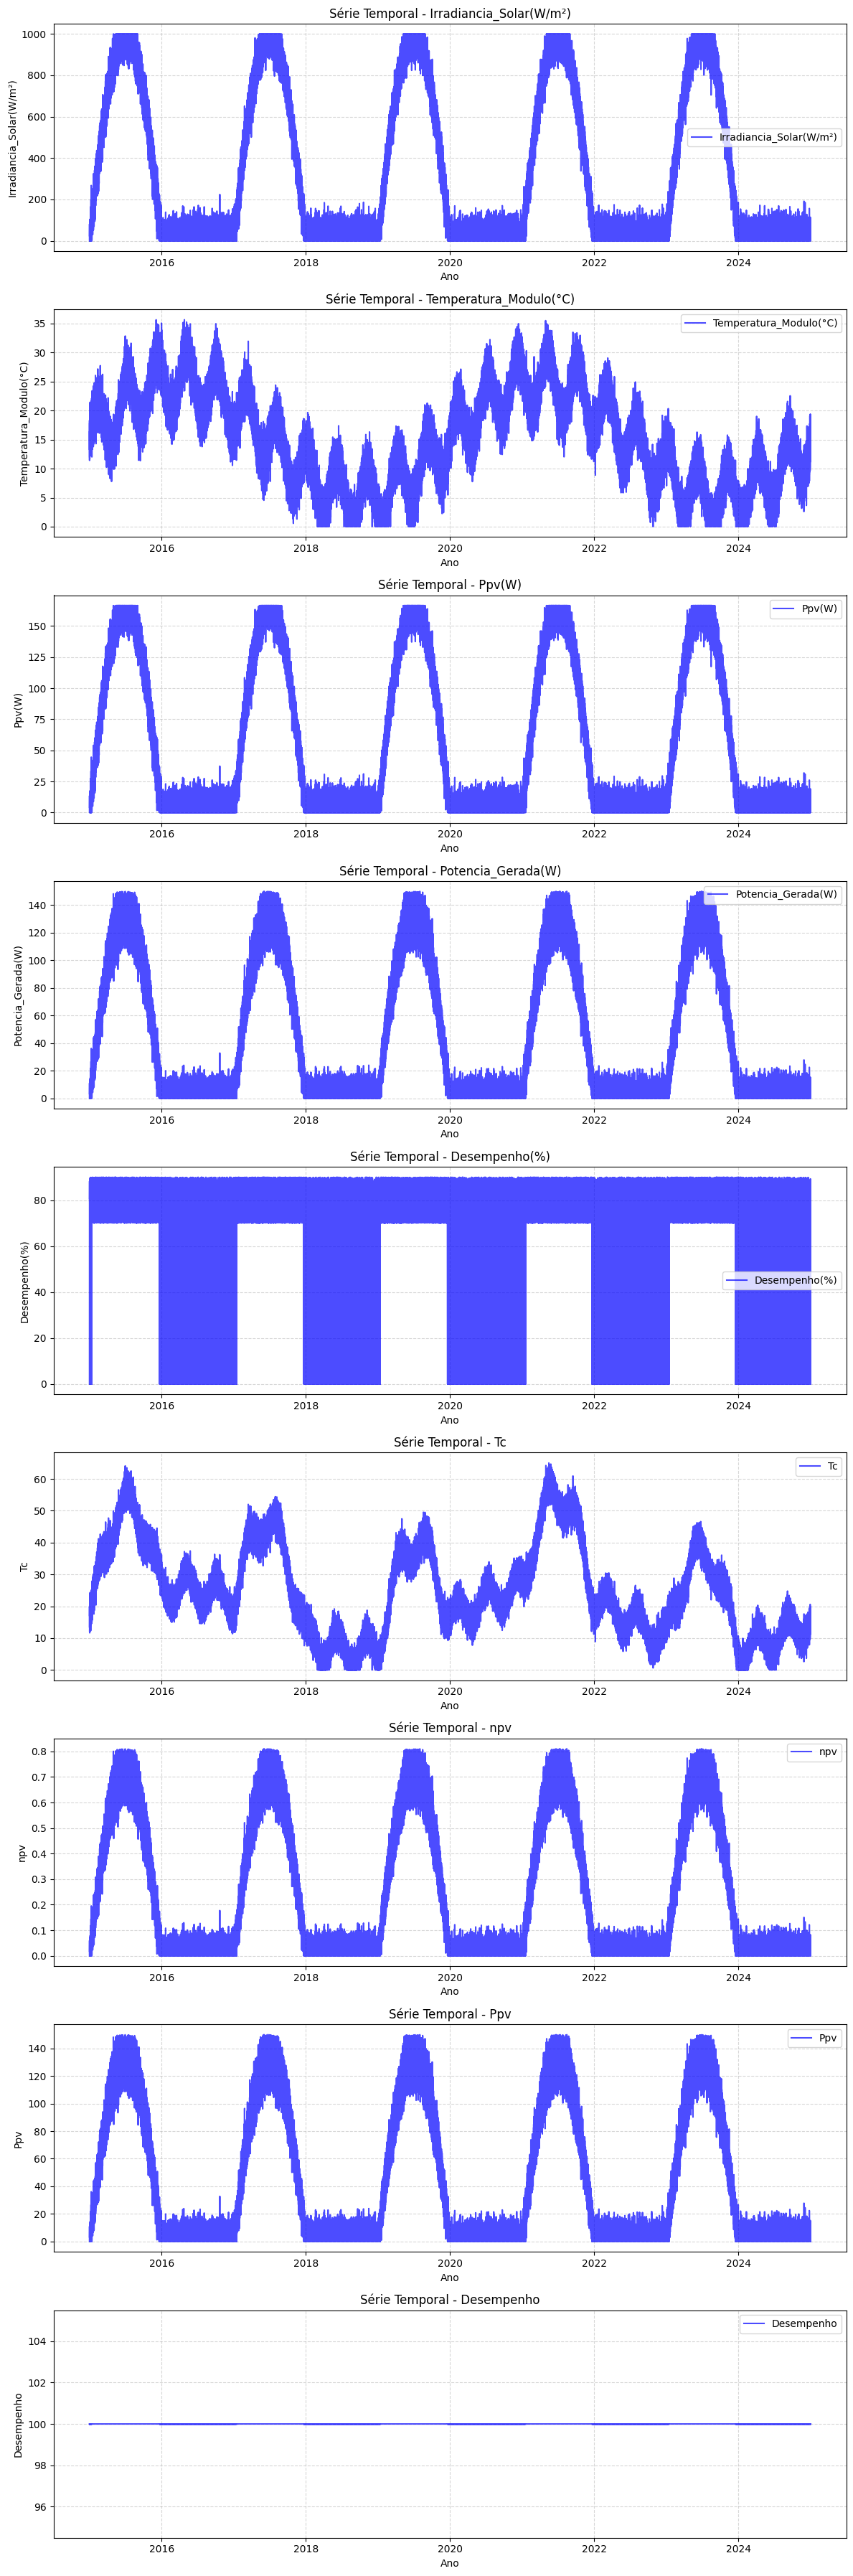

✅ Gráficos de séries temporais gerados.


In [40]:
# Séries temporais

# 📌 Carregar os dados processados
df.set_index('Timestamp', inplace=True)

# 📌 Selecionar apenas colunas numéricas para análise
df_numeric = df.select_dtypes(include=['number'])

# 📌 Criar gráficos de séries temporais para cada coluna numérica
fig, axes = plt.subplots(nrows=len(df_numeric.columns), ncols=1, figsize=(12, 4 * len(df_numeric.columns)))

for ax, col in zip(axes, df_numeric.columns):
    ax.plot(df_numeric.index, df_numeric[col], label=col, color='blue', alpha=0.7)
    ax.set_title(f'Série Temporal - {col}', fontsize=12)
    ax.set_xlabel('Ano')
    ax.set_ylabel(col)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

# 📌 Ajuste de layout para evitar sobreposição
plt.tight_layout()
plt.show()

print("✅ Gráficos de séries temporais gerados.")


In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# 📌 Carregar os dados processados
df = pd.read_csv('dados_processados.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# 📊 📉 **Comparação entre Potências**
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Ppv'], label='Potência Teórica (Ppv)', linestyle='dashed', color='red')
plt.plot(df.index, df['Potencia_Gerada(W)'], label='Potência Gerada', color='blue')
plt.xlabel('Tempo')
plt.ylabel('Potência (W)')
plt.title('Comparação entre Potência Teórica e Potência Gerada')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

print("✅ Comparação entre potências gerada e teórica concluída.")

✅ Comparação entre potências gerada e teórica concluída.


In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Carregar os dados processados
df = pd.read_csv('dados_processados.csv')

# 📊 🔍 **Heatmap de Correlação**
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Irradiancia_Solar(W/m²)', 'Temperatura_Modulo(°C)', 'Potencia_Gerada(W)', 'Desempenho']].corr(),
            annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlação entre variáveis")
plt.show()

print("✅ Heatmap de correlação gerado.")


✅ Heatmap de correlação gerado.


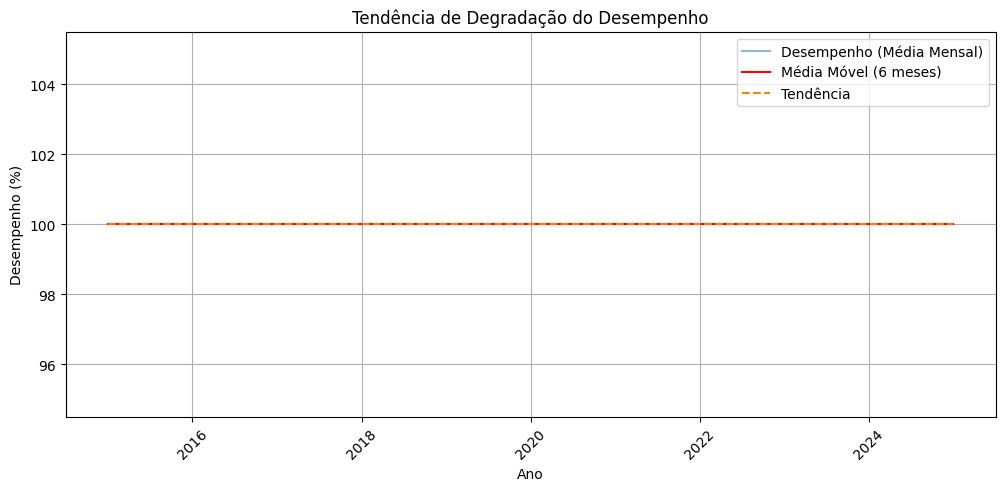

✅ Análise de degradação do desempenho concluída.


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 📌 Carregar os dados processados
df = pd.read_csv('dados_processados.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# 📉 **Tendência de Degradação do Desempenho**
df['YearMonth'] = df.index.to_period('M')
df_monthly = df.groupby('YearMonth').agg({'Desempenho': 'mean'}).reset_index()
df_monthly['YearMonth'] = df_monthly['YearMonth'].dt.to_timestamp()

# 📌 Criar um eixo X normalizado para regressão
x = np.arange(len(df_monthly))

# 📌 Aplicar média móvel para suavizar tendências
df_monthly['Desempenho_Suavizado'] = df_monthly['Desempenho'].rolling(window=6, min_periods=1).mean()

# 📌 Regressão linear para tendência de Desempenho
slope, intercept, _, _, _ = linregress(x, df_monthly['Desempenho_Suavizado'])
df_monthly['Desempenho_Tendencia'] = intercept + slope * x

# 📉 📊 **Gráfico da Degradação do Desempenho**
plt.figure(figsize=(12, 5))
plt.plot(df_monthly['YearMonth'], df_monthly['Desempenho'], label='Desempenho (Média Mensal)', alpha=0.5)
plt.plot(df_monthly['YearMonth'], df_monthly['Desempenho_Suavizado'], label='Média Móvel (6 meses)', color='red')
plt.plot(df_monthly['YearMonth'], df_monthly['Desempenho_Tendencia'], linestyle='dashed', label='Tendência')
plt.xlabel("Ano")
plt.ylabel("Desempenho (%)")
plt.title("Tendência de Degradação do Desempenho")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

print("✅ Análise de degradação do desempenho concluída.")


In [44]:
# Mineração de processos DFG
# 📌 Criar níveis de potência para mineração de processos
def definir_nivel_energia(potencia):
    if potencia < 100:
        return "1"
    elif 100 <= potencia < 300:
        return "2"
    else:
        return "3"

df['Energy_Level'] = df['Potencia_Gerada(W)'].apply(definir_nivel_energia)

# 📌 Criar um identificador de evento para cada amostra
df['event_id'] = range(len(df))

# 📌 Criar um identificador único para cada dia (case ID)
df['case_id'] = df['Timestamp'].astype(str).str[:10]  # Usa a data como identificador de caso

# 📌 Criar coluna de nome do evento
df['concept:name'] = df['Energy_Level']

# 📌 Selecionar colunas para mineração de processos
df_event_log = df[['case_id', 'event_id', 'Timestamp', 'concept:name']]
df_event_log = df_event_log.rename(columns={'Timestamp': 'time:timestamp'})

# 📌 Converter dataframe para um log de eventos no formato pm4py
event_log = pm4py.format_dataframe(df_event_log, case_id='case_id', activity_key='concept:name', timestamp_key='time:timestamp')

# Criar a coluna prev_energy_level
df['prev_energy_level'] = df['concept:name'].shift(1)

# **🔹 Remover valores nulos antes da filtragem de eventos**
df.dropna(subset=['prev_energy_level'], inplace=True)

# Converter níveis de energia para string para evitar problemas no grafo
df['concept:name'] = df['concept:name'].astype(str)
df['prev_energy_level'] = df['prev_energy_level'].astype(str)

# 🔹 Filtrar apenas eventos onde há mudança de nível de energia
df_filtered = df[df['concept:name'] != df['prev_energy_level']].copy()

# 🔹 Depuração: verificar quantos eventos temos
print(f"Total de eventos no DataFrame original: {len(df)}")
print(f"Total de eventos após filtragem de mudanças de nível de energia: {len(df_filtered)}")

# 🔹 Contar quantas vezes cada transição ocorre
transitions = list(zip(df_filtered['prev_energy_level'], df_filtered['concept:name']))
transition_counts = Counter(transitions)

print("\n🔹 Frequência das transições detectadas:")
for trans, freq in transition_counts.most_common():
    print(f"Transição {trans[0]} → {trans[1]} ocorreu {freq} vezes")

# 🔹 Criar manualmente o DFG
G = nx.DiGraph()

# Adicionar as transições ao grafo
for (source, target), freq in transition_counts.items():
    G.add_edge(source, target, weight=freq)

# 🔹 Verificar se há transições suficientes para exibição
if len(G.edges) == 0:
    print("⚠️ Nenhuma transição válida encontrada para visualização.")
else:
    print(f"Total de transições exibidas no grafo: {len(G.edges)}")

    # Ajustar o layout para melhor distribuição dos nós
    pos = nx.spring_layout(G, seed=42)

    # Criar a figura
    plt.figure(figsize=(10, 8))

    # Desenhar os nós e arestas
    nx.draw(G, pos, with_labels=True, node_size=2500, node_color="lightblue", edge_color="gray",
            font_size=12, font_weight="bold", arrows=True, arrowsize=20)

    # Adicionar rótulos com a frequência das transições
    edge_labels = {(source, target): f"{freq}" for (source, target), freq in transition_counts.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color="red")

    # Salvar o gráfico
    plt.savefig("process_model_dfg.png", dpi=300)
    plt.show()

print("✅ Modelo de processos gerado com pm4py.")


KeyError: 'Timestamp'